In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/SARS-COV2-Classification/python

/content/drive/MyDrive/SARS-COV2-Classification/python


In [4]:
import pandas as pd
import numpy as np

In [21]:
df = pd.read_csv("../labeled_protein_sequences.csv")
df.head()

,Sequence_ID,Protein_Sequence,Label
0,UIF27901.1,ITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFLYIIKLIF...,1
1,QJX19961.1,MAFSASLFKPVQLVPVSPAFHRIESTDSIVFTYIPASGYVAALAVN...,0
2,UMG10730.1,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...,1
3,ASU90795.1,MAFSASLFKPVQLVPVSPAFHRIESPDSIVFTYIPASGYVAALAVN...,0
4,UBU60787.1,MDLFMRIFTIGTVTLKQGEIKDATPLDFVRATATIPIQASLPFGWL...,1


In [22]:
# Drop rows with missing values
df = df.dropna()
# Make sure sequences are uppercase
df['Protein_Sequence'] = df['Protein_Sequence'].str.upper()

In [23]:
import re

# Valid amino acids
valid_amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

# Keep only sequences made up of valid amino acids
pattern = f'^[{valid_amino_acids}]+$'
df = df[df['Protein_Sequence'].str.match(pattern)]


In [24]:
df.shape

(15860, 3)

In [25]:
import numpy as np

# List of 20 standard amino acids
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

def aac_encoding(sequence):
    """Returns the frequency of each amino acid in the sequence."""
    sequence = sequence.upper()
    length = len(sequence)
    return np.array([sequence.count(aa) / length for aa in amino_acids])


In [26]:
!pip install torch
!pip install torch-geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [37]:
import torch
from torch_geometric.data import Data
import pandas as pd
import numpy as np

df = pd.read_csv("../labeled_protein_sequences.csv")
amino_acids = 'ACDEFGHIKLMNPQRSTVWY'

def aac_encoding(sequence):
    sequence = sequence.upper()
    length = len(sequence)
    return np.array([sequence.count(aa) / length for aa in amino_acids])

df['feature_vector'] = df['Protein_Sequence'].apply(aac_encoding)
X = np.vstack(df['feature_vector'].values)
X_tensor = torch.tensor(X, dtype=torch.float)


In [38]:
pip install networkx matplotlib

In [39]:
labels = torch.tensor(df['Label'].values, dtype=torch.long)



In [40]:
from sklearn.neighbors import NearestNeighbors

# Choose a number of neighbors (you can tune this)
k = 10

# Fit KNN model with cosine metric
knn = NearestNeighbors(n_neighbors=k, metric='cosine', algorithm='auto')
knn.fit(X)

# Get top-k neighbors for each node
distances, indices = knn.kneighbors(X)

edge_index_list = []

for i in range(len(indices)):
    for j, dist in zip(indices[i], distances[i]):
        if i != j and 1 - dist > 0.85:  # cosine similarity = 1 - cosine distance
            edge_index_list.append([i, j])
            edge_index_list.append([j, i])  # undirected

edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()


In [41]:
from torch_geometric.data import Data

data = Data(x=X_tensor, edge_index=edge_index, y=labels)


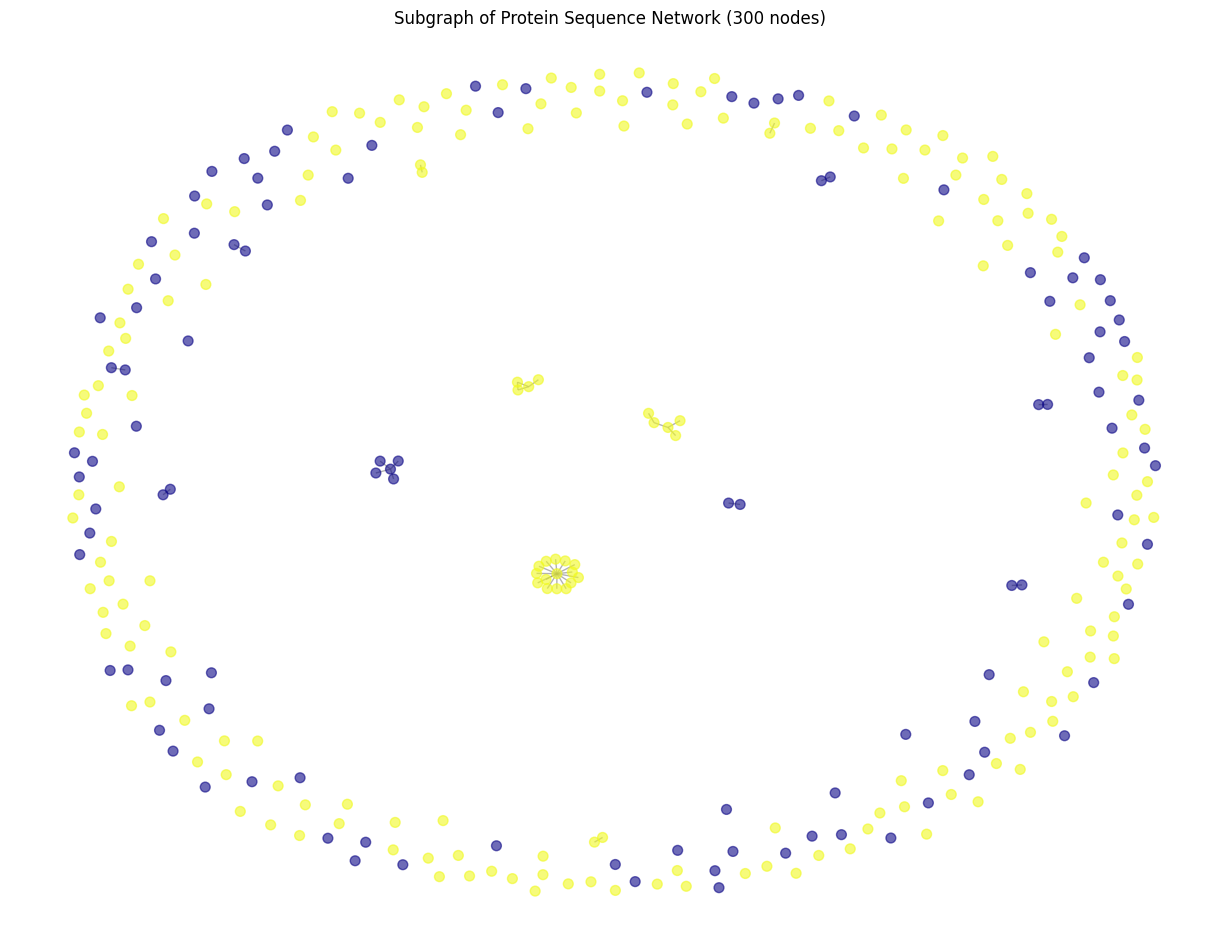

In [42]:
import torch
from torch_geometric.utils import subgraph
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Choose a subset of nodes (e.g., first 300)
subset_nodes = torch.arange(300)

# Create subgraph
sub_edge_index, _ = subgraph(subset_nodes, data.edge_index, relabel_nodes=True)
sub_data = Data(x=data.x[subset_nodes], edge_index=sub_edge_index, y=data.y[subset_nodes])

# Convert to NetworkX
G = to_networkx(sub_data, to_undirected=True)

# Layout and draw
pos = nx.spring_layout(G, seed=42)  # Use spring layout for good spacing

plt.figure(figsize=(12, 9))
nx.draw(
    G,
    pos,
    node_color=sub_data.y.numpy(),
    node_size=50,
    cmap='plasma',
    with_labels=False,
    edge_color="gray",
    alpha=0.6
)
plt.title("Subgraph of Protein Sequence Network (300 nodes)")
plt.show()


In [43]:
from sklearn.model_selection import train_test_split

num_nodes = data.num_nodes
train_idx, test_idx = train_test_split(
    np.arange(num_nodes),
    test_size=0.2,
    stratify=data.y.numpy(),
    random_state=42
)

data.train_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.train_mask[train_idx] = True

data.test_mask = torch.zeros(num_nodes, dtype=torch.bool)
data.test_mask[test_idx] = True


In [44]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(in_channels=data.num_node_features, hidden_channels=64, out_channels=len(torch.unique(data.y))).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = nn.CrossEntropyLoss()

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean()
    return acc.item()


In [46]:
for epoch in range(1, 201):
    loss = train()
    if epoch % 20 == 0 or epoch == 1:
        acc = test()
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | Test Acc: {acc:.4f}")


Epoch 001 | Loss: 0.6871 | Test Acc: 0.6230
Epoch 020 | Loss: 0.5860 | Test Acc: 0.6753
Epoch 040 | Loss: 0.4378 | Test Acc: 0.7957
Epoch 060 | Loss: 0.2800 | Test Acc: 0.9184
Epoch 080 | Loss: 0.1909 | Test Acc: 0.9580
Epoch 100 | Loss: 0.1548 | Test Acc: 0.9701
Epoch 120 | Loss: 0.1379 | Test Acc: 0.9733
Epoch 140 | Loss: 0.1276 | Test Acc: 0.9750
Epoch 160 | Loss: 0.1197 | Test Acc: 0.9753
Epoch 180 | Loss: 0.1142 | Test Acc: 0.9756
Epoch 200 | Loss: 0.1098 | Test Acc: 0.9750
